<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Probabilistic/Bayesian/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic layers and Bayesian neural networks

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    tensorflow tensorflow-probability tf_keras

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

#### Use the forward model to create probabilistic training data

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


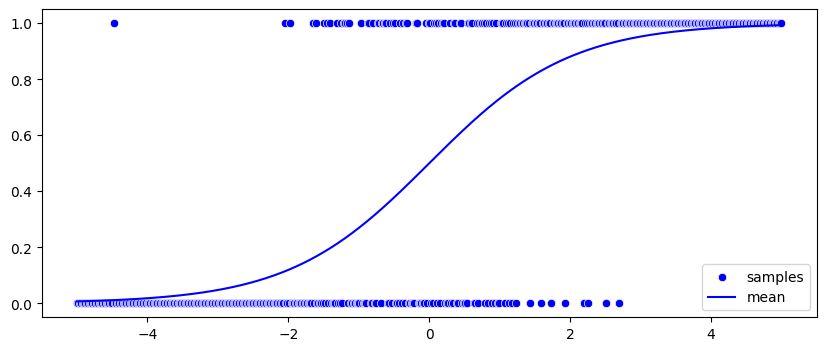

In [ ]:
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.random.set_seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

# Create a sigmoid model, first deterministic, then probabilistic
x = tf_keras.Input(shape=(1,), dtype=tf.float32)
h = tf_keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.constant_initializer(1),
    bias_initializer=tf.constant_initializer(0))(inputs=x)
y = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
    tfp.distributions.Bernoulli(probs=t),
    convert_to_tensor_fn=tfp.distributions.Distribution.sample)(inputs=h)
sampling_model = tf_keras.Model(inputs=x, outputs=y)
sampling_model.summary()

# Use the model to create 500 training points
x_train = tf.linspace(start=-5, stop=5, num=500)[:, tf.newaxis]
y_train = sampling_model.predict(x=x_train, verbose=0)
mean_train = sampling_model(inputs=x_train).mean()

ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.cache().shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)

# Plot the data and the mean of the distribution
plt.figure(figsize=(10, 4))
sns.scatterplot(x=x_train[:, 0], y=y_train[:, 0],
    color="blue", label="samples")
sns.lineplot(x=x_train[:, 0], y=mean_train[:, 0],
    color="blue", label="mean")
plt.show()

#### Create a new probabilistic model with the wrong weights

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time
import tf_keras
import tensorflow as tf
import tensorflow_probability as tfp
tf.random.set_seed(seed=42)

# Create a new version of the model, with the wrong weights
x = tf_keras.Input(shape=(1,), dtype=tf.float32)
h = tf_keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.constant_initializer(2),
    bias_initializer=tf.constant_initializer(2))(inputs=x)
y = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
    tfp.distributions.Bernoulli(probs=t),
    convert_to_tensor_fn=tfp.distributions.Distribution.sample)(inputs=h)
training_model = tf_keras.Model(inputs=x, outputs=y)
training_model.summary()

# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

# Compile untrained model
training_model.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

metrics = [
    tf.keras.metrics.Mean(name="loss")
]

@tf.function
def train_step(x, y):
    vars = training_model.trainable_variables
    with tf.GradientTape() as tape:
        y_pred = training_model(inputs=x, training=True)
        loss = nll(y_true=y, y_pred=y_pred)
        grads = tape.gradient(target=loss, sources=vars)
    training_model.optimizer.apply_gradients(
        grads_and_vars=zip(grads, vars))

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"train_{m.name}": m.result() for m in metrics}

# Train model, record weights after each epoch
start_time = time.time()
num_epochs = 500
history = []
for _ in range(num_epochs):
    for x, y in ds_train:
        result = train_step(x=x, y=y)
    logs = {k: v.numpy() for k, v in result.items()}
    logs.update({"train_weight": training_model.weights[0].numpy()[0, 0]})
    logs.update({"train_bias": training_model.weights[1].numpy()[0]})
    history.append(logs)
    for m in metrics:
        m.reset_state()
print("Training duration: %2.fs"%(time.time() - start_time))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 distribution_lambda_1 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training duration:  8s


#### Train the new model with the negative loglikelihood

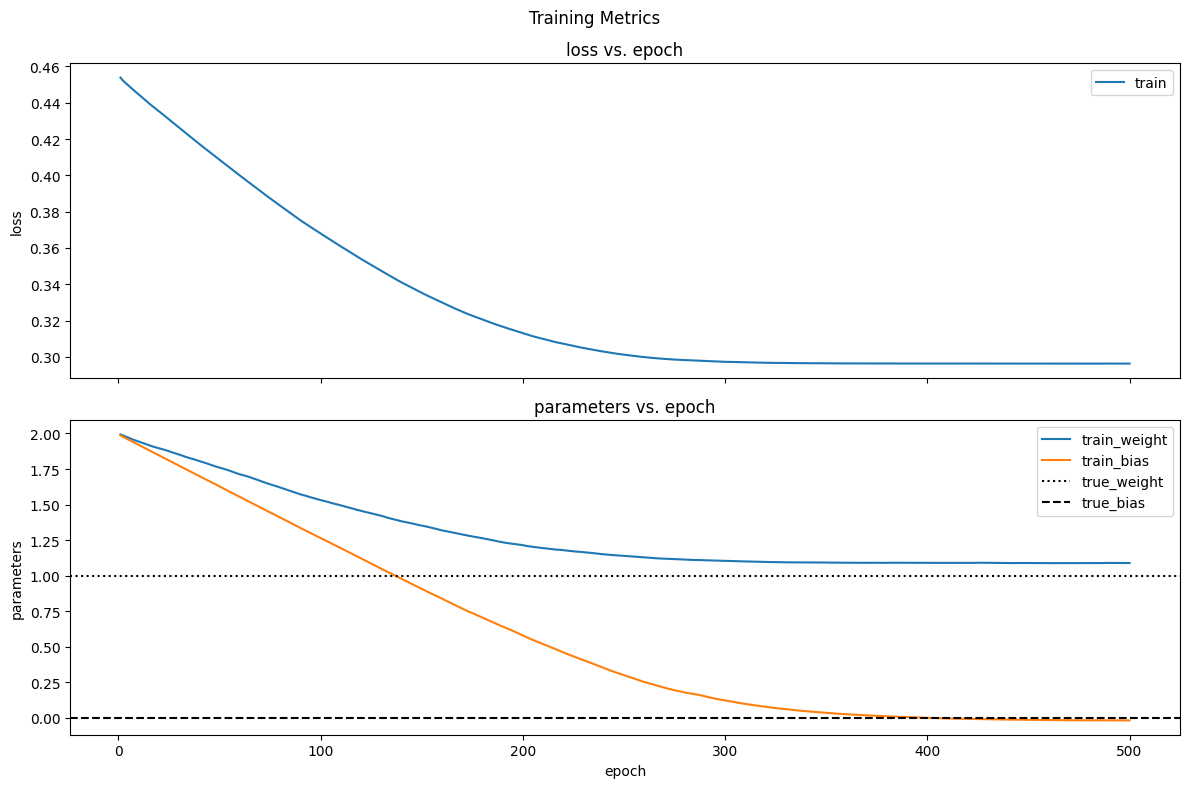

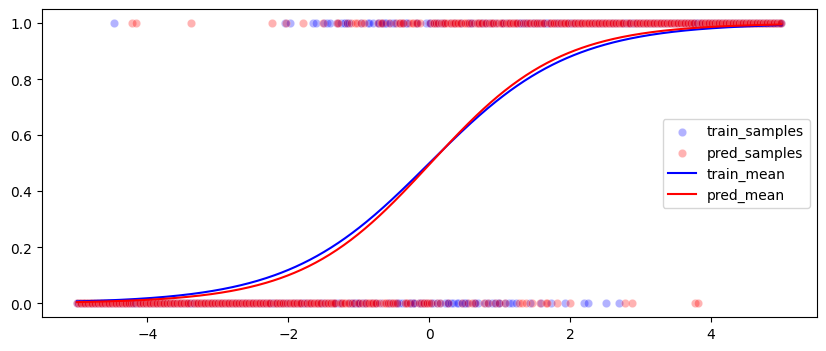

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
sns.lineplot(ax=axes[0], data=df_history, label="train",
    x="epoch", y="train_loss")
axes[0].legend(loc="best")
axes[0].set_ylabel(ylabel="loss")
axes[0].set_title(label="loss vs. epoch")
# Plot the model weights as they train, converging to the correct values
for m in ["weight", "bias"]:
    sns.lineplot(ax=axes[1], data=df_history, label=f"train_{m}",
        x="epoch", y=f"train_{m}")
axes[1].set_xlabel(xlabel="epoch")
axes[1].set_ylabel(ylabel="parameters")
axes[1].set_title(label=f"parameters vs. epoch")
axes[1].axhline(y=1, label="true_weight", color="k", linestyle=":")
axes[1].axhline(y=0, label="true_bias", color="k", linestyle="--")
axes[1].legend(loc="best")
fig.tight_layout()
plt.show()

y_pred = training_model(inputs=x_train)
mean_pred = training_model(inputs=x_train).mean()

plt.figure(figsize=(10, 4))
sns.scatterplot(x=x_train[:, 0], y=y_train[:, 0],
    color="blue", alpha=0.3, label="train_samples")
sns.scatterplot(x=x_train[:, 0], y=y_pred[:, 0],
    color="red", alpha=0.3, label="pred_samples")
sns.lineplot(x=x_train[:, 0], y=mean_train[:, 0],
    color="blue", label="train_mean")
sns.lineplot(x=x_train[:, 0], y=mean_pred[:, 0],
    color="red", label="pred_mean")
plt.show()

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


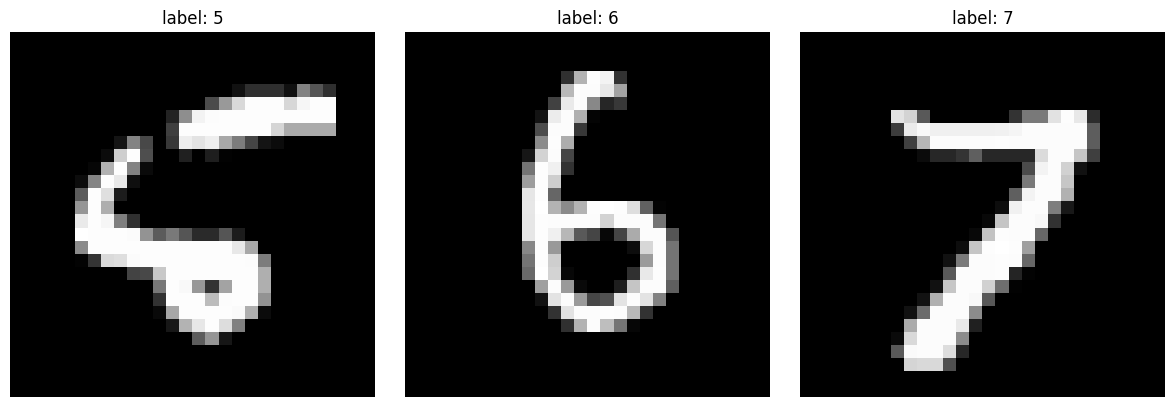

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))

In [ ]:
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)
import matplotlib.pyplot as plt

num_classes = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = tf.keras.utils.to_categorical(x=y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(x=y_test, num_classes=num_classes)

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {tf.math.argmax(input=y)}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

x = tf_keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf_keras.layers.Rescaling(scale=1./255)(inputs=x)
y = tf_keras.layers.Reshape(target_shape=(28, 28, 1))(inputs=h)
preprocessing_model = tf_keras.Model(inputs=x, outputs=y)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(inputs=x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time
import os
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)
import tensorflow_probability as tfp

x = tf_keras.Input(shape=(28, 28, 1), dtype=tf.float32)
h = tf_keras.layers.Conv2D(filters=16, kernel_size=(3, 3),
    activation=tf.keras.activations.relu)(inputs=x)
h = tf_keras.layers.MaxPooling2D(pool_size=(3, 3))(inputs=h)
h = tf_keras.layers.Flatten()(inputs=h)
h = tf_keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf_keras.layers.Dropout(rate=0.2)(inputs=h)
h = tf_keras.layers.Dense(units=tfp.layers.OneHotCategorical.params_size(
        event_size=num_classes))(inputs=h)
y = tfp.layers.OneHotCategorical(event_size=num_classes,
    convert_to_tensor_fn=tfp.distributions.Distribution.sample)(inputs=h)
training_model = tf_keras.Model(inputs=x, outputs=y)
training_model.summary()

def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

training_model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.CategoricalAccuracy(name="acc")
]

@tf.function
def train_step(x, y):
    vars = training_model.trainable_variables
    with tf.GradientTape() as tape:
        y_pred = training_model(inputs=x, training=True)
        loss = nll(y_true=y, y_pred=y_pred)
        grads = tape.gradient(target=loss, sources=vars)
    training_model.optimizer.apply_gradients(
        grads_and_vars=zip(grads, vars))

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function
def test_step(x, y):
    y_pred = training_model(inputs=x, training=False)
    loss = nll(y_true=y, y_pred=y_pred)

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"test_{m.name}": m.result() for m in metrics}

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True,
    filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=training_model,
    add_history=True, callbacks=[ckptModel, reduceLR])

start_time = time.time()
num_epochs = 10
history = []
callbacks.on_train_begin(logs=None)
for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=None)

    for x, y in ds_train:
        result = train_step(x=x, y=y)
    logs = {k: v.numpy() for k, v in result.items()}
    for m in metrics:
        m.reset_state()

    for x, y in ds_test:
        result = test_step(x=x, y=y)
    logs.update({k: v.numpy() for k, v in result.items()})
    history.append(logs)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
callbacks.on_train_end(logs=None)
print("Training duration: %2.fs"%(time.time() - start_time))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 16)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                           

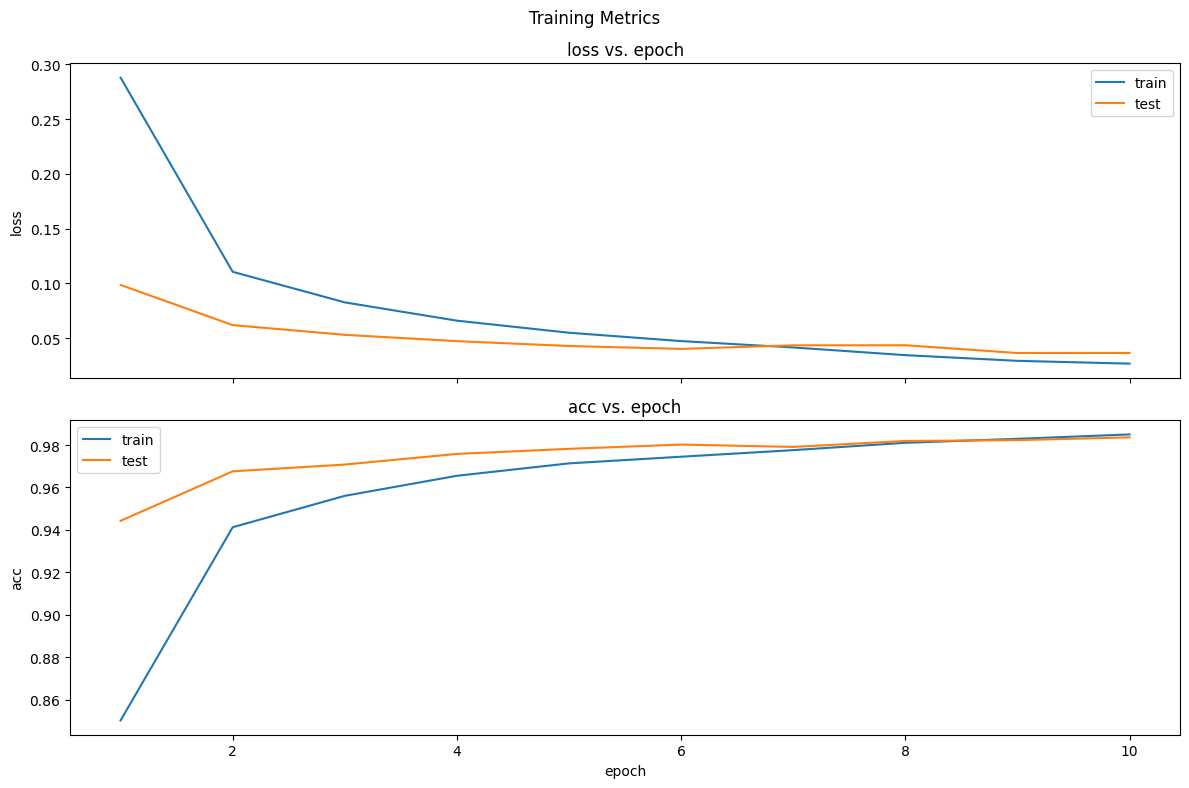

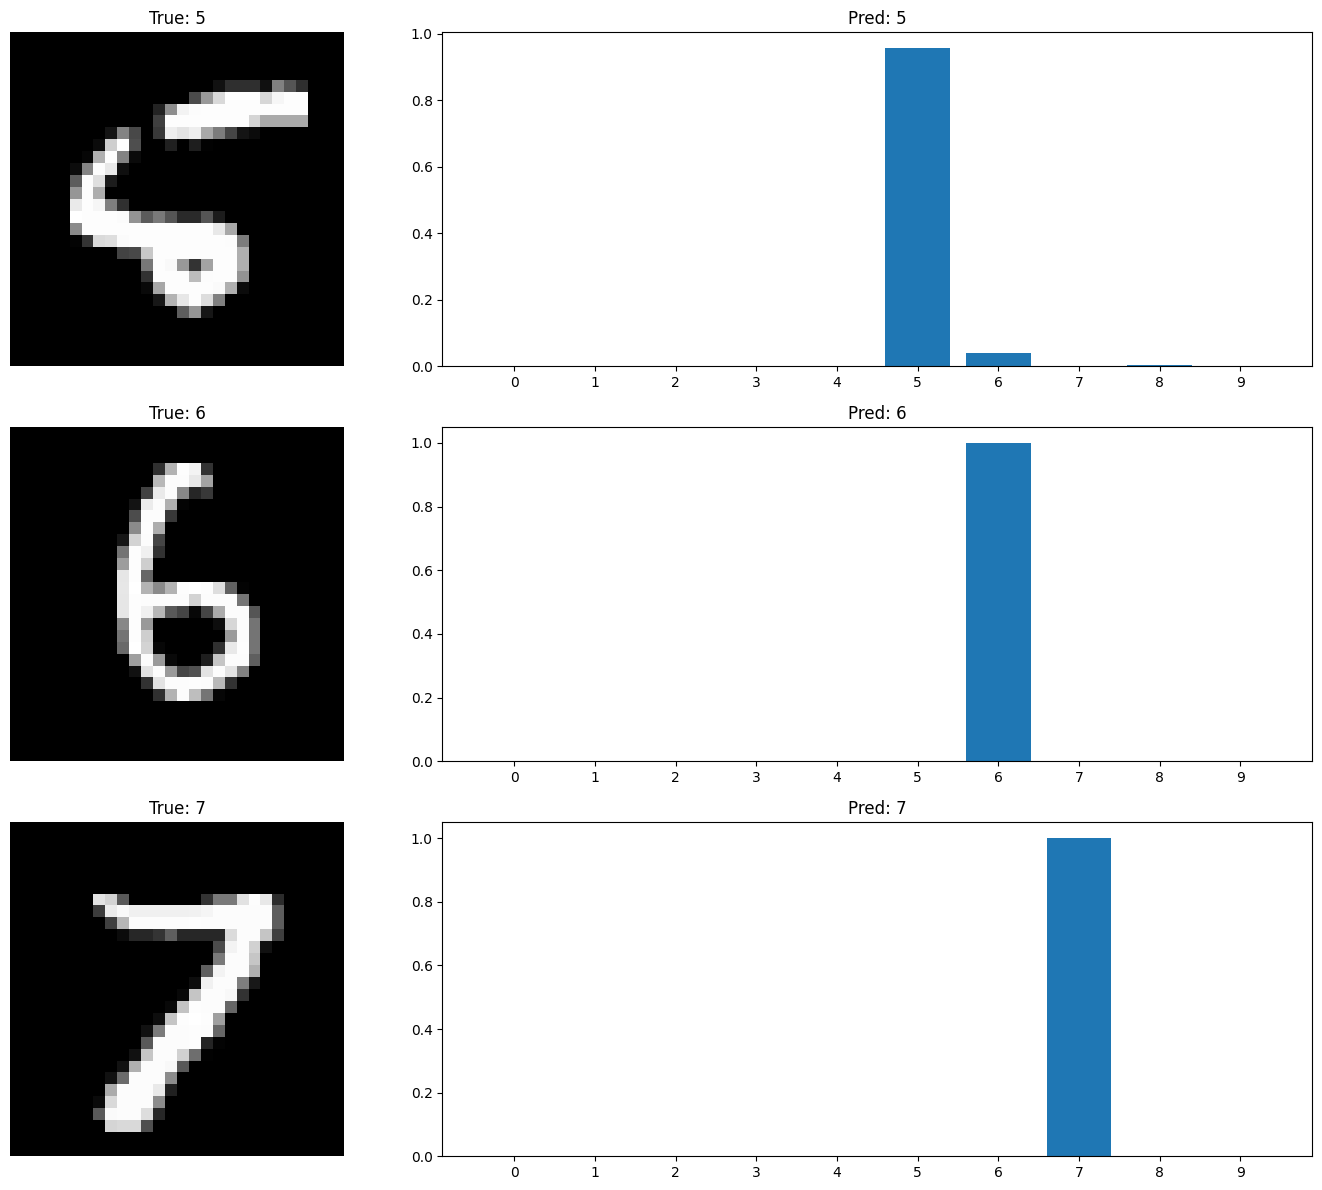

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history, label="train",
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, data=df_history, label="test",
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=m.name)
    ax.set_title(label=f"{m.name} vs. epoch")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
plt.show()

training_model.load_weights(ckptPath)
x = preprocessing_model.input
y = training_model(inputs=preprocessing_model(inputs=x))
inference_model = tf_keras.Model(inputs=x, outputs=y)

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
distrib = inference_model(inputs=x_plt, training=False)
probs = distrib.mean()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {tf.math.argmax(input=y)}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i =  x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

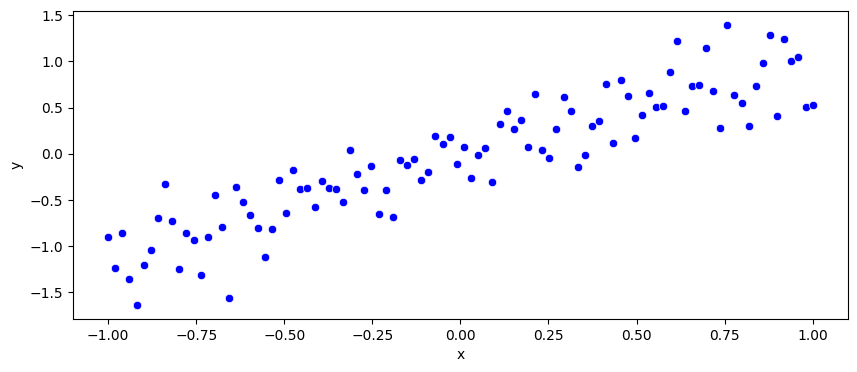

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

# Create and plot 100 points of training data
num_samples = 100
x_train = tf.linspace(start=-1., stop=1., num=num_samples)[:, tf.newaxis]
y_train = x_train + 0.3*tf.random.normal(shape=(num_samples, 1))
ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.cache().shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

plt.figure(figsize=(10, 4))
x = x_train[:, 0]
y = y_train[:, 0]
sns.scatterplot(x=x, y=y, color="blue")
plt.xlabel(xlabel="x")
plt.ylabel(ylabel="y")
plt.show()

#### Probabilistic linear regression with both user-defined and learned variance

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time
import os
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)
import tensorflow_probability as tfp

# Create and train probabilistic regression
# with normal distribution as final layer
x = tf_keras.Input(shape=(1,), dtype=tf.float32)
h = tf_keras.layers.Dense(units=2)(inputs=x)
y = tfp.layers.DistributionLambda(make_distribution_fn=lambda t:
    tfp.distributions.Independent(tfp.distributions.Normal(
            loc=t[:, :1], scale=tf.math.softplus(t[:, 1:])),
        reinterpreted_batch_ndims=0),
    convert_to_tensor_fn=tfp.distributions.Distribution.sample)(inputs=h)
model = tf_keras.Model(inputs=x, outputs=y)
model.summary()

# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)

metrics = [
    tf.keras.metrics.Mean(name="loss")
]

@tf.function
def train_step(x, y):
    vars = model.trainable_variables
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = nll(y_true=y, y_pred=y_pred)
        grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(
        grads_and_vars=zip(grads, vars))

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"train_{m.name}": m.result() for m in metrics}

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="train_loss",
    mode="min", save_best_only=True, save_weights_only=True,
    filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="train_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model,
    add_history=True, callbacks=[ckptModel, reduceLR])

start_time = time.time()
num_epochs = 100
history = []
callbacks.on_train_begin(logs=None)
for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=None)

    for x, y in ds_train:
        result = train_step(x=x, y=y)
    logs = {k: v.numpy() for k, v in result.items()}
    history.append(logs)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
callbacks.on_train_end(logs=None)
print("Training duration: %2.fs"%(time.time() - start_time))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 2)                 4         
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training duration:  5s


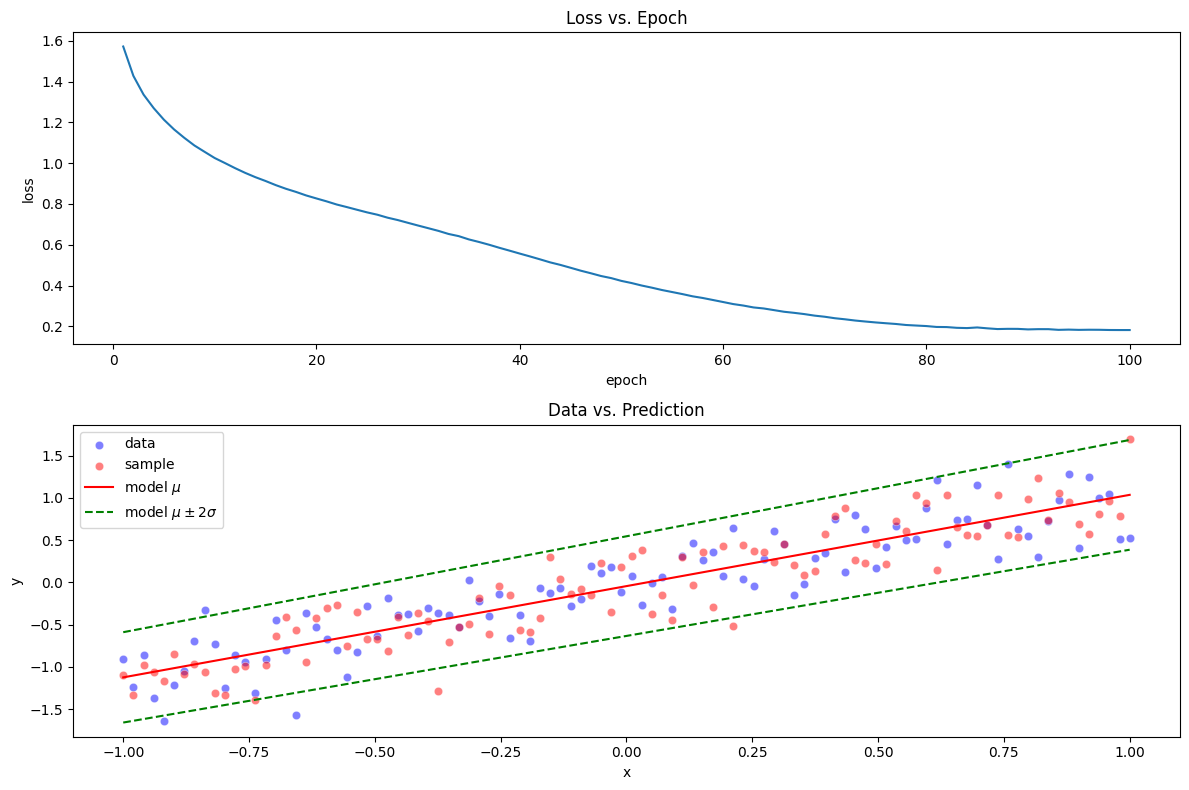

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axes[0].set_xlabel(xlabel="epoch")
axes[0].set_ylabel(ylabel="loss")
axes[0].set_title(label="Loss vs. Epoch")
sns.lineplot(ax=axes[0], data=df_history, x="epoch", y="train_loss")

# Plot the data and a sample from the model
model.load_weights(ckptPath)
distrib = model(inputs=x_train)
y_pred = distrib.sample()
mean_pred = distrib.mean()
stddev_pred = distrib.stddev()

axes[1].set_xlabel(xlabel="x")
axes[1].set_ylabel(ylabel="y")
axes[1].set_title(label="Data vs. Prediction")
x = x_train[:, 0]
y = y_train[:, 0]
sns.scatterplot(ax=axes[1], label="data", color="blue", alpha=0.5,
    x=x, y=y)
y = y_pred[:, 0]
sns.scatterplot(ax=axes[1], label="sample", color="red", alpha=0.5,
    x=x, y=y)
y = mean_pred[:, 0]
sns.lineplot(ax=axes[1], label="model $\mu$", color="red",
    x=x, y=y)
y = mean_pred[:, 0] + 2*stddev_pred[:, 0]
sns.lineplot(ax=axes[1], label="model $\mu \pm 2 \sigma$", color="green",
    linestyle="--", x=x, y=y)
y = mean_pred[:, 0] - 2*stddev_pred[:, 0]
sns.lineplot(ax=axes[1], color="green", linestyle="--",
    x=x, y=y)
axes[1].legend(loc="best")

fig.tight_layout()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

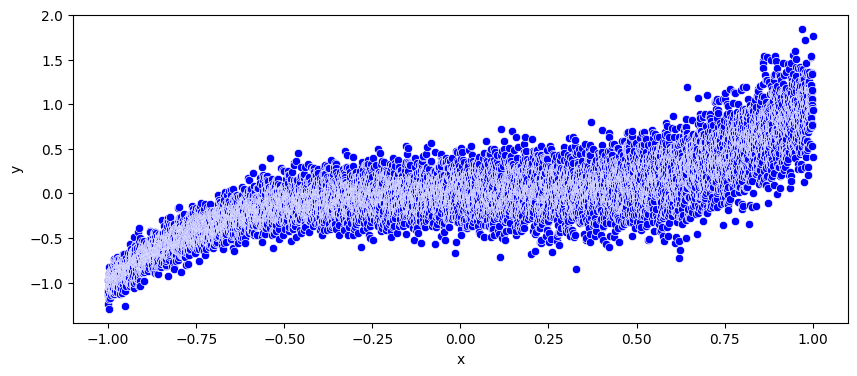

In [16]:
import tensorflow as tf
tf.random.set_seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

# Create and plot 1000 data points
num_samples = 10000
x_train = tf.linspace(start=-1., stop=1., num=num_samples)[:, tf.newaxis]
y_train = tf.math.pow(x=x_train, y=3) + \
    0.1*(2 + x_train)*tf.random.normal(shape=(num_samples, 1))
ds_train = tf.data.Dataset.from_tensor_slices(tensors=(x_train, y_train))
ds_train = ds_train.cache().shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

plt.figure(figsize=(10, 4))
x = x_train[:, 0]
y = y_train[:, 0]
sns.scatterplot(x=x, y=y, color="blue")
plt.xlabel(xlabel="x")
plt.ylabel(ylabel="y")
plt.show()

In [17]:
import warnings
warnings.filterwarnings("ignore")
import time
import os
import tf_keras
import tensorflow as tf
tf.random.set_seed(seed=42)
import tensorflow_probability as tfp

# Create probabilistic regression:
# normal distribution with fixed variance
event_shape = 1
x = tf_keras.Input(shape=(1,), dtype=tf.float32)
h = tf_keras.layers.Dense(units=8,
    activation=tf.keras.activations.sigmoid)(inputs=x)
h = tf_keras.layers.Dense(units=tfp.layers.IndependentNormal.params_size(
    event_shape=event_shape))(inputs=h)
y = tfp.layers.IndependentNormal(event_shape=event_shape,
    convert_to_tensor_fn=tfp.distributions.Distribution.sample)(inputs=h)
model = tf_keras.Model(inputs=x, outputs=y)
model.summary()

# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(value=y_true)

model.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

metrics = [
    tf.keras.metrics.Mean(name="loss")
]

# Train model
@tf.function
def train_step(x, y):
    vars = model.trainable_variables
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=False)
        loss = nll(y_true=y, y_pred=y_pred)
        grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))

    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f"train_{m.name}": m.result() for m in metrics}

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="train_loss",
    mode="min", save_best_only=True, save_weights_only=True,
    filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="train_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model,
    add_history=True, callbacks=[ckptModel, reduceLR])

start_time = time.time()
num_epochs = 200
history = []
callbacks.on_train_begin(logs=None)
for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=None)

    for x, y in ds_train:
        result = train_step(x=x, y=y)
    logs = {k: v.numpy() for k, v in result.items()}
    history.append(logs)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
callbacks.on_train_end(logs=None)
print("Training duration: %2.fs"%(time.time() - start_time))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 16        
                                                                 
 dense_9 (Dense)             (None, 2)                 18        
                                                                 
 independent_normal_4 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 34 (136.00 Byte)
Trainable params: 34 (136.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training duration: 118s


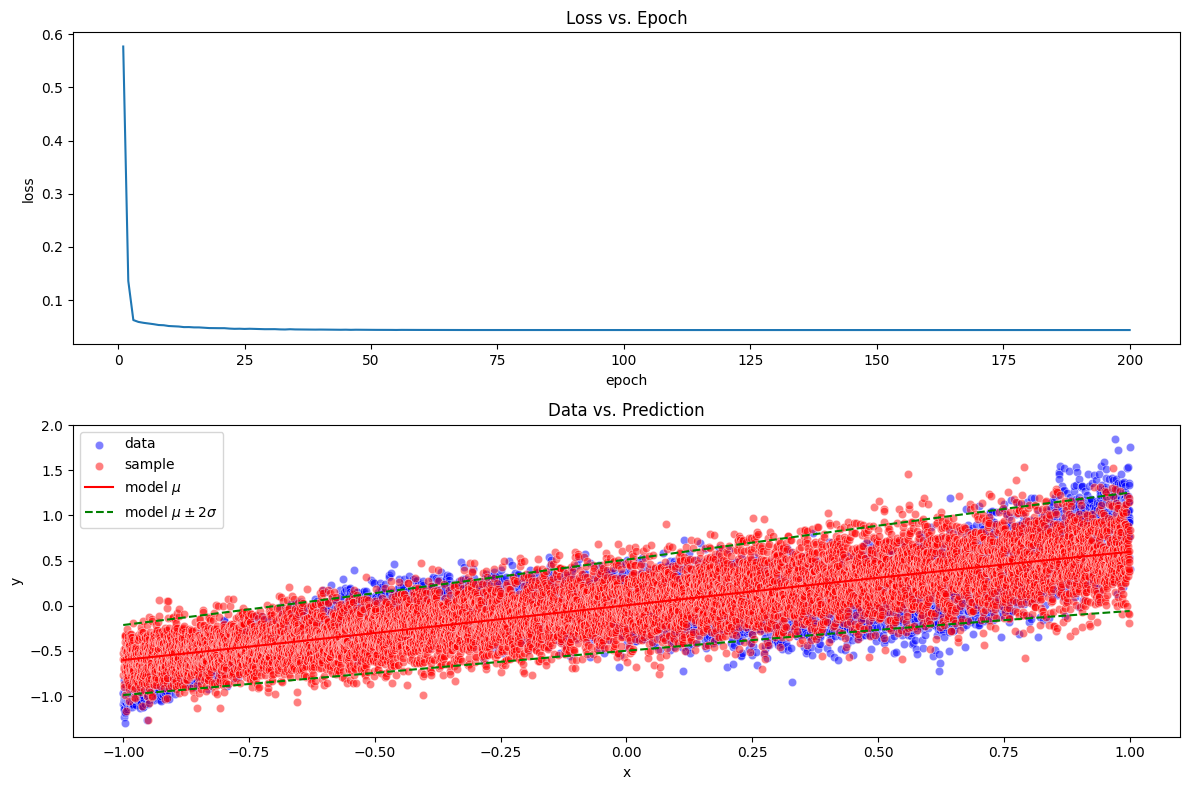

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
axes[0].set_xlabel(xlabel="epoch")
axes[0].set_ylabel(ylabel="loss")
axes[0].set_title(label=f"Loss vs. Epoch")
sns.lineplot(ax=axes[0], data=df_history, x="epoch", y="train_loss")

# Plot the data and a sample from the model
model.load_weights(ckptPath)
distrib = model(inputs=x_train)
y_pred = distrib.sample()
mean_pred = distrib.mean()
stddev_pred = distrib.stddev()

axes[1].set_xlabel(xlabel="x")
axes[1].set_ylabel(ylabel="y")
axes[1].set_title(label="Data vs. Prediction")
x = x_train[:, 0]
y = y_train[:, 0]
sns.scatterplot(ax=axes[1], label="data", color="blue", alpha=0.5,
    x=x, y=y)
y = y_pred[:, 0]
sns.scatterplot(ax=axes[1], label="sample", color="red", alpha=0.5,
    x=x, y=y)
y = mean_pred[:, 0]
sns.lineplot(ax=axes[1], label="model $\mu$", color="red",
    x=x, y=y)
y = mean_pred[:, 0] + 2*stddev_pred[:, 0]
sns.lineplot(ax=axes[1], label="model $\mu \pm 2 \sigma$", color="green",
    linestyle="--", x=x, y=y)
y = mean_pred[:, 0] - 2*stddev_pred[:, 0]
sns.lineplot(ax=axes[1], color="green", linestyle="--",
    x=x, y=y)
axes[1].legend(loc="best")
fig.tight_layout()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(2),
    tfpl.IndependentNormal(1)])
model.summary()

model.compile(loss=lambda y_true, y_pred:
    -y_pred.log_prob(y_true),
    optimizer=RMSprop(learning_rate=0.01),
    metrics=[MeanAbsoluteError()])

x_train = np.random.normal(size=(1000, 8))
y_train = np.random.normal(size=(1000,))
history = model.fit(x_train, y_train, validation_split=0.1,
    epochs=200, batch_size=32, verbose=0)
# plot training history
plot_df = pd.DataFrame(history.history)
epoch = np.arange(1, len(plot_df)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
ax1.plot(epoch, plot_df['loss'], label='Training')
ax1.plot(epoch, plot_df['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(1, 3)
ax1.set_title("Loss vs Epoch")
ax1.legend()
# Mean absolute error plot
ax2.plot(epoch, plot_df['mean_absolute_error'], label='Training')
ax2.plot(epoch, plot_df['val_mean_absolute_error'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean absolute error')
ax2.set_title("Mean absolute error vs Epoch")
ax2.legend()
plt.show()

x_test = np.random.normal(size=(1, 8))
y_test = np.random.normal(size=(1,))
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mse: {test_mse:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
        reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),
            dtype=dtype),
        tfpl.IndependentNormal(n,
            convert_to_tensor_fn=tfd.Distribution.sample)])

# ELBO:
# q = q(w | theta)
# E_{w ~ q}[log p(D | w)] - KL[q || p]
#     = Sum_i E_{w ~ q}[log p(D_i | w)] - KL[q || p]

# For a minibatch:
# N/B * Sum_j E_{w ~ q}[log p(D_j | w)] - KL[q || p]

# Per example loss:
# 1/B * Sum_j E_{w ~q}[log p(D_j | w)] - 1/N * KL[q || p]

N=1000
model = Sequential([
    tfpl.DenseVariational(16, posterior, prior,
        kl_weight=1/N, kl_use_exact=True,
        activation='relu', input_shape=(8,)),
    tfpl.DenseVariational(2, posterior, prior,
        kl_weight=1/N, kl_use_exact=True),
    tfpl.IndependentNormal(1)])
model.summary()

model.compile(loss=lambda y_true, y_pred:
    -y_pred.log_prob(y_true),
    optimizer=RMSprop(learning_rate=0.01),
    metrics=[MeanAbsoluteError()])

x_train = np.random.normal(size=(N, 8))
y_train = np.random.normal(size=(N,))
history = model.fit(x_train, y_train, validation_split=0.1,
    epochs=200, batch_size=32, verbose=0)
# plot training history
plot_df = pd.DataFrame(history.history)
epoch = np.arange(1, len(plot_df)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
ax1.plot(epoch, plot_df['loss'], label='Training')
ax1.plot(epoch, plot_df['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(1, 3)
ax1.set_title("Loss vs Epoch")
ax1.legend()
# Mean absolute error plot
ax2.plot(epoch, plot_df['mean_absolute_error'], label='Training')
ax2.plot(epoch, plot_df['val_mean_absolute_error'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean absolute error')
ax2.set_title("Mean absolute error vs Epoch")
ax2.legend()
plt.show()

x_test = np.random.normal(size=(1, 8))
y_test = np.random.normal(size=(1,))
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mse: {test_mse:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(2*n, dtype=dtype),
        tfpl.DistributionLambda(lambda t:
            tfd.Independent(tfd.Normal(loc=t[..., :n],
                scale=tf.math.softplus(t[..., n:])),
            reinterpreted_batch_ndims=1))])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),
            dtype=dtype),
        tfpl.IndependentNormal(n,
            convert_to_tensor_fn=tfd.Distribution.sample)])

N=1000
input = Input(shape=(8,), name='Input')
h = tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N,
    kl_use_exact=True, activation='relu', name='DV01')(input)
h = tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N,
    kl_use_exact=True, name='DV02')(h)
output = tfpl.IndependentNormal(1, name='Output')(h)
model = Model(inputs=input, outputs=output)
# model = Sequential([
#     tfpl.DenseVariational(16, posterior, prior,
#         kl_weight=1/N, kl_use_exact=True,
#         activation='relu', input_shape=(8,)),
#     tfpl.DenseVariational(2, posterior, prior,
#         kl_weight=1/N, kl_use_exact=True),
#     tfpl.IndependentNormal(1)
# ])
model.summary()

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
    optimizer=RMSprop(learning_rate=1e-2),
    metrics=[MeanAbsoluteError()])

train_x = np.random.normal(size=(N, 8))
train_y = np.random.normal(size=(N,))
history = model.fit(train_x, train_y, validation_split=0.1,
    epochs=200, batch_size=32, verbose=0)

# Training history plot
figs = PlotMetrics(history=history,
    metrics=['loss', 'mean_absolute_error'])
figs.plot()

test_x = np.random.normal(size=(100, 8))
test_y = np.random.normal(size=(100,))
test_loss, test_mse = model.evaluate(test_x, test_y, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mae: {test_mae:.4f}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

In [ ]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n),
            scale_diag=tf.ones(n)))])
    return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),
            dtype=dtype),
        tfpl.MultivariateNormalTriL(n)])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad
\epsilon_i \sim N(0, \sigma^2), \quad
\alpha \sim N(0, 1), \quad
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$
\mathbf{\mu}
=
\mathbf{\Sigma}
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} =
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [ ]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], kl_use_exact=True)])

model.compile(loss=MeanSquaredError(),
    optimizer=RMSprop(learning_rate=0.005))

model.summary()

#### Train model and inspect

In [ ]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [ ]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

In [ ]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)
plt.legend()
plt.show()

#### Explore the effect of sample size

In [ ]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [ ]:
# Train a model on each dataset

model_1000 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/1000)])

model_100 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(),
    optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(),
    optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

In [ ]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),
    sharex=True, sharey=True)

for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)

plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [ ]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8, input_shape=(1,),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], activation='sigmoid'),

    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0]),

    tfpl.IndependentNormal(1)])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

In [ ]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, MaxPool2D
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3],
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=tfpl.default_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def custom_multivariate_normal_fn(dtype, shape, name, trainable,
    add_variable_fn):
    normal = tfd.Normal(loc=tf.zeros(shape, dtype),
        scale=2 * tf.ones(shape, dtype))
    batch_ndims = tf.size(normal.batch_shape_tensor())
    return tfd.Independent(normal,
        reinterpreted_batch_ndims=batch_ndims)

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3],
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=custom_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_2 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dataset_size = 1000

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3],
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_posterior_tensor_fn=tfd.Distribution.sample,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
        bias_posterior_tensor_fn=tfd.Distribution.sample,
        bias_prior_fn=None,
        kernel_divergence_fn=(lambda q, p, _: tfd.kl_divergence(q, p) / dataset_size)),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_8  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_8 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_8 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

The goal is to use the accelerometer data to predict the activity.

In [ ]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

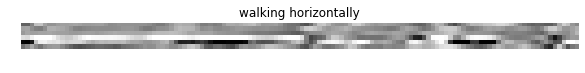

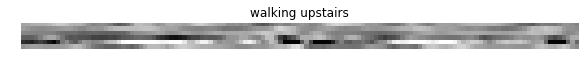

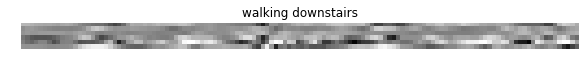

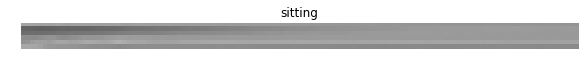

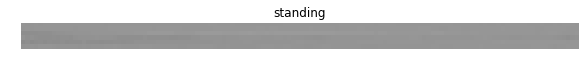

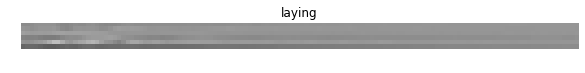

In [ ]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()

make_plots(1)

#### 1D deterministic convolutional neural network

In [ ]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [ ]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(input_shape=(128, 6),
        filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_1  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [ ]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [ ]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 1s 202us/sample - loss: 0.8495 - accuracy: 0.7251


[0.8494912760264598, 0.7251442]

#### Inspect model performance

In [ ]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


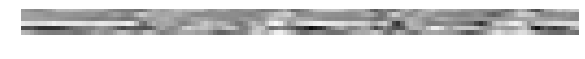

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


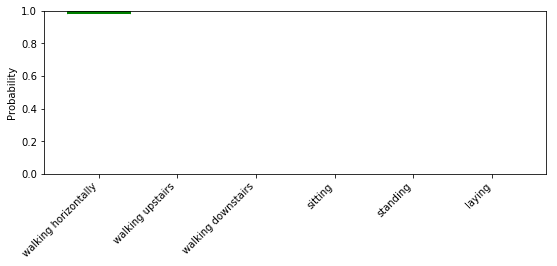

In [ ]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


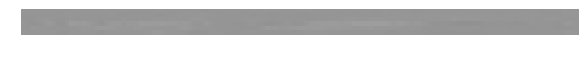

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


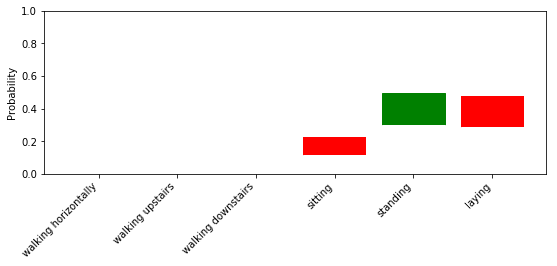

In [ ]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


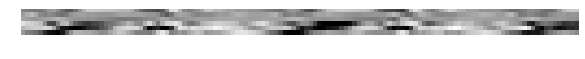

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


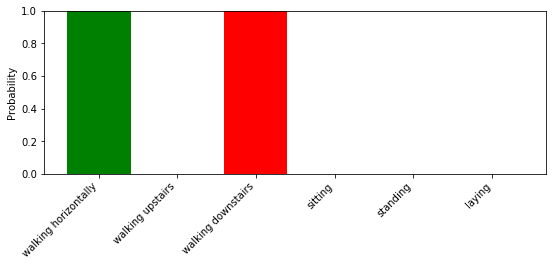

In [ ]:
analyse_model_predictions(image_num=1137)